# Project on Resume Classification

# Business objective:
The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention

# A. Text Extraction from Resumes

## A1.Importing Library

In [1]:
import os
import re
import nltk
import spacy
import string
import textract
import pandas as pd
import seaborn as sns
from matplotlib import pylab
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings('ignore')

In [2]:
full_path = 'resumes categorised'
path=os.listdir(full_path)

In [3]:
file_path1 = []
category1  = []
directory1 = full_path

In [4]:

for i in os.listdir(directory1):
    if i.endswith('.docx'):
        os.path.join(directory1, i)
        file_path1.append((textract.process(os.path.join(directory1, i))).decode('utf-8'))
        file_name = os.path.splitext(i)[0]
        category1.append(file_name)

In [5]:
data1 = pd.read_csv('all_resumes.csv')
data1.columns = ['Raw_Details','Category1']

# A2. Data Understanding

## A2.1 Number of Words in each Resume

In [6]:
data1.isnull().sum()

Raw_Details    0
Category1      0
dtype: int64

In [7]:
data1['Word_Count'] = data1['Raw_Details'].apply(lambda x: len(str(x).split(" ")))
data1[['Raw_Details','Word_Count']].head()

,Raw_Details,Word_Count
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,361
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,2435
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,404
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",349
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,357


## A2.2 Number of Characters

In [8]:
data1['Char_Count'] = data1['Raw_Details'].str.len() ## this also includes spaces
data1[['Raw_Details','Char_Count']].head()

,Raw_Details,Char_Count
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,3702
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,6115
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,2669
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",3156
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,2672


## A2.3 Number of Stopwords

In [9]:
import nltk
# nltk.download('stopwords')
stop = stopwords.words('english')
data1['Stopwords'] = data1['Raw_Details'].apply(lambda x: len([x for x in x.split() if x in stop]))
data1[['Raw_Details','Stopwords']]

,Raw_Details,Stopwords
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,112
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,115
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,106
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",93
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,48
...,...,...
74,\n CURRICULUM VIT...,301
75,Ranga Gaganam \n\n\n\n \n\nProfessional\n\n \...,86
76,SHAIK ABDUL SHARUK \n\n2 years’ Experience i...,64
77,MAREEDU LOKESH BABU\n\n\n\nPROFESSIONAL OVERVI...,67


## A2.4 Number of Numerics

In [10]:
data1['Numerics'] = data1['Raw_Details'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data1[['Raw_Details','Numerics']].head()

,Raw_Details,Numerics
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,2
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,8
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,6
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",5
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,8


In [11]:
data1

,Raw_Details,Category1,Word_Count,Char_Count,Stopwords,Numerics
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,React,361,3702,112,2
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,React,2435,6115,115,8
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,React,404,2669,106,6
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",React,349,3156,93,5
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,React,357,2672,48,8
...,...,...,...,...,...,...
74,\n CURRICULUM VIT...,Reactjs,26196,35291,301,26
75,Ranga Gaganam \n\n\n\n \n\nProfessional\n\n \...,Reactjs,435,3299,86,4
76,SHAIK ABDUL SHARUK \n\n2 years’ Experience i...,Reactjs,474,3111,64,9
77,MAREEDU LOKESH BABU\n\n\n\nPROFESSIONAL OVERVI...,Reactjs,945,2967,67,4


# A3. Text Pre-Processing

## A3.1 Using Regular Expression

In [12]:
def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    return " ".join(filtered_words)

In [13]:
data1['Resume_Details'] = data1.Raw_Details.apply(lambda x: preprocess(x))

## A3.2 Clean Text from Resume

In [14]:
data1

,Raw_Details,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,React,361,3702,112,2,developer react developer name krishna profess...
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,React,2435,6115,115,8,pic profile searching opportunity bring years ...
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,React,404,2669,106,6,haripriya battina experience developer reactjs...
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,React,357,2672,48,8,kamalakar reddy linked professional summary ye...
...,...,...,...,...,...,...,...
74,\n CURRICULUM VIT...,Reactjs,26196,35291,301,26,curriculum vitae anjani priyadarshini objectiv...
75,Ranga Gaganam \n\n\n\n \n\nProfessional\n\n \...,Reactjs,435,3299,86,4,ranga gaganam professional summary professiona...
76,SHAIK ABDUL SHARUK \n\n2 years’ Experience i...,Reactjs,474,3111,64,9,shaik abdul sharuk years experience wipro care...
77,MAREEDU LOKESH BABU\n\n\n\nPROFESSIONAL OVERVI...,Reactjs,945,2967,67,4,mareedu lokesh babu professional overview arou...


## A3.3 Save the Clean Data in new CSV File

In [15]:
data1.drop(['Raw_Details'], axis = 1, inplace = True)
data1

,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details
0,React,361,3702,112,2,developer react developer name krishna profess...
1,React,2435,6115,115,8,pic profile searching opportunity bring years ...
2,React,404,2669,106,6,haripriya battina experience developer reactjs...
3,React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...
4,React,357,2672,48,8,kamalakar reddy linked professional summary ye...
...,...,...,...,...,...,...
74,Reactjs,26196,35291,301,26,curriculum vitae anjani priyadarshini objectiv...
75,Reactjs,435,3299,86,4,ranga gaganam professional summary professiona...
76,Reactjs,474,3111,64,9,shaik abdul sharuk years experience wipro care...
77,Reactjs,945,2967,67,4,mareedu lokesh babu professional overview arou...


In [16]:
data1.to_csv('Cleaned_Resumes.csv', index = False)

In [17]:
resume_data = pd.read_csv('Cleaned_Resumes.csv')
resume_data

,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details
0,React,361,3702,112,2,developer react developer name krishna profess...
1,React,2435,6115,115,8,pic profile searching opportunity bring years ...
2,React,404,2669,106,6,haripriya battina experience developer reactjs...
3,React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...
4,React,357,2672,48,8,kamalakar reddy linked professional summary ye...
...,...,...,...,...,...,...
74,Reactjs,26196,35291,301,26,curriculum vitae anjani priyadarshini objectiv...
75,Reactjs,435,3299,86,4,ranga gaganam professional summary professiona...
76,Reactjs,474,3111,64,9,shaik abdul sharuk years experience wipro care...
77,Reactjs,945,2967,67,4,mareedu lokesh babu professional overview arou...


In [18]:
resume_data.Resume_Details[5]

'thirupathamma balla summary year experience react developer worked technologies like react javascript experience developing business applications internet using react experience object oriented programming concepts strong analytical ability skills enthusiastic eager meet challenges quick learn assimilate new concepts ideas ability work efficiently either independently team minimal supervision without ever missing deadline brief profile work experience year current employer predifast technologies private limited react developer industry software software services highest degree tech eee current hyderabad date birth gender november summary skills experience work experience duration mar till date company predifast technologies private limited designation react developer job profile develop javascript based applications using react technical skills languages web technologies react bootstrap javascript json education course institution percentage year passing electrical electronics enginee

# A4. Named Entity Recognition (NER)

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/its_relative/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resume_data['Resume_Details'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = preprocess(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('experience', 598), ('peoplesoft', 453), ('workday', 431), ('application', 418), ('using', 395), ('server', 359), ('data', 332), ('project', 326), ('reports', 326), ('sql', 280), ('business', 273), ('web', 250), ('database', 243), ('process', 236), ('worked', 220), ('knowledge', 216), ('client', 197), ('system', 192), ('involved', 191), ('tools', 190), ('integrations', 189), ('integration', 183), ('hcm', 182), ('like', 180), ('support', 178), ('skills', 171), ('good', 169), ('development', 168), ('team', 166), ('creating', 164), ('working', 162), ('technical', 160), ('people', 160), ('services', 157), ('report', 155), ('design', 154), ('servers', 152), ('testing', 150), ('created', 150), ('react', 148), ('various', 146), ('role', 142), ('oracle', 142), ('developer', 139), ('environment', 139), ('responsibilities', 137), ('management', 136), ('security', 134), ('eib', 134), ('production', 133)]


# A5. Parts Of Speech (POS) Tagging

In [23]:
import spacy

spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:04


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
one_block = cleanedSentences[1300:5200]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style= 'ent', jupyter= True)

In [25]:
for token in doc_block[:30]:
    print(token,token.pos_)  

project NOUN
role NOUN
developer NOUN
react VERB
developer NOUN
responsibilities NOUN
design NOUN
develop VERB
test NOUN
html PROPN
css PROPN
bootstrap PROPN
javascript PROPN
react VERB
meets VERB
accessibility NOUN
web NOUN
browser NOUN
standards NOUN
website NOUN
developed VERB
user NOUN
interface NOUN
using AUX
react VERB
flux NOUN
spa NOUN
development NOUN
used VERB
react VERB


## A5.1 Filtering out only the Nouns and Verbs from the Text to Tokens

In [26]:
one_block = cleanedSentences
doc_block = nlp(one_block)
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[:250])

['developer', 'react', 'developer', 'name', 'summary', 'years', 'experience', 'react', 'web', 'developer', 'year', 'experience', 'react', 'software', 'developer', 'experience', 'developing', 'web', 'pages', 'using', 'react', 'phase', 'requirement', 'analysis', 'implementation', 'maintenance', 'experience', 'knowledge', 'developing', 'page', 'applications', 'spas', 'expertise', 'analyzing', 'document', 'object', 'model', 'script', 'functions', 'cascading', 'styles', 'cross', 'browser', 'using', 'fire', 'bug', 'developer', 'tool', 'bar', 'expertise', 'react', 'framework', 'develop', 'spa', 'react', 'working', 'react', 'flux', 'architecture', 'experienced', 'working', 'architecture', 'using', 'object', 'concepts', 'improving', 'performance', 'websites', 'experience', 'using', 'react', 'components', 'forms', 'events', 'keys', 'router', 'expertise', 'video', 'coding', 'using', 'javascript', 'expertise', 'soap', 'web', 'services', 'integrate', 'application', 'application', 'experience', 'fro

## A5.2 Counting all the Nouns and Verbs present in the Tokens of words

In [27]:
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)

words_freq = [(word,sum_words[0,idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df = pd.DataFrame(words_freq)
wd_df.columns = ['Words','Count']
wd_df[0:15]

,Words,Count
0,experience,542
1,application,417
2,using,384
3,workday,352
4,reports,326
5,data,307
6,project,289
7,business,260
8,server,242
9,web,237


## A5.3 Visualizing the Result of Top 20 Nouns and Verbs most Frequently

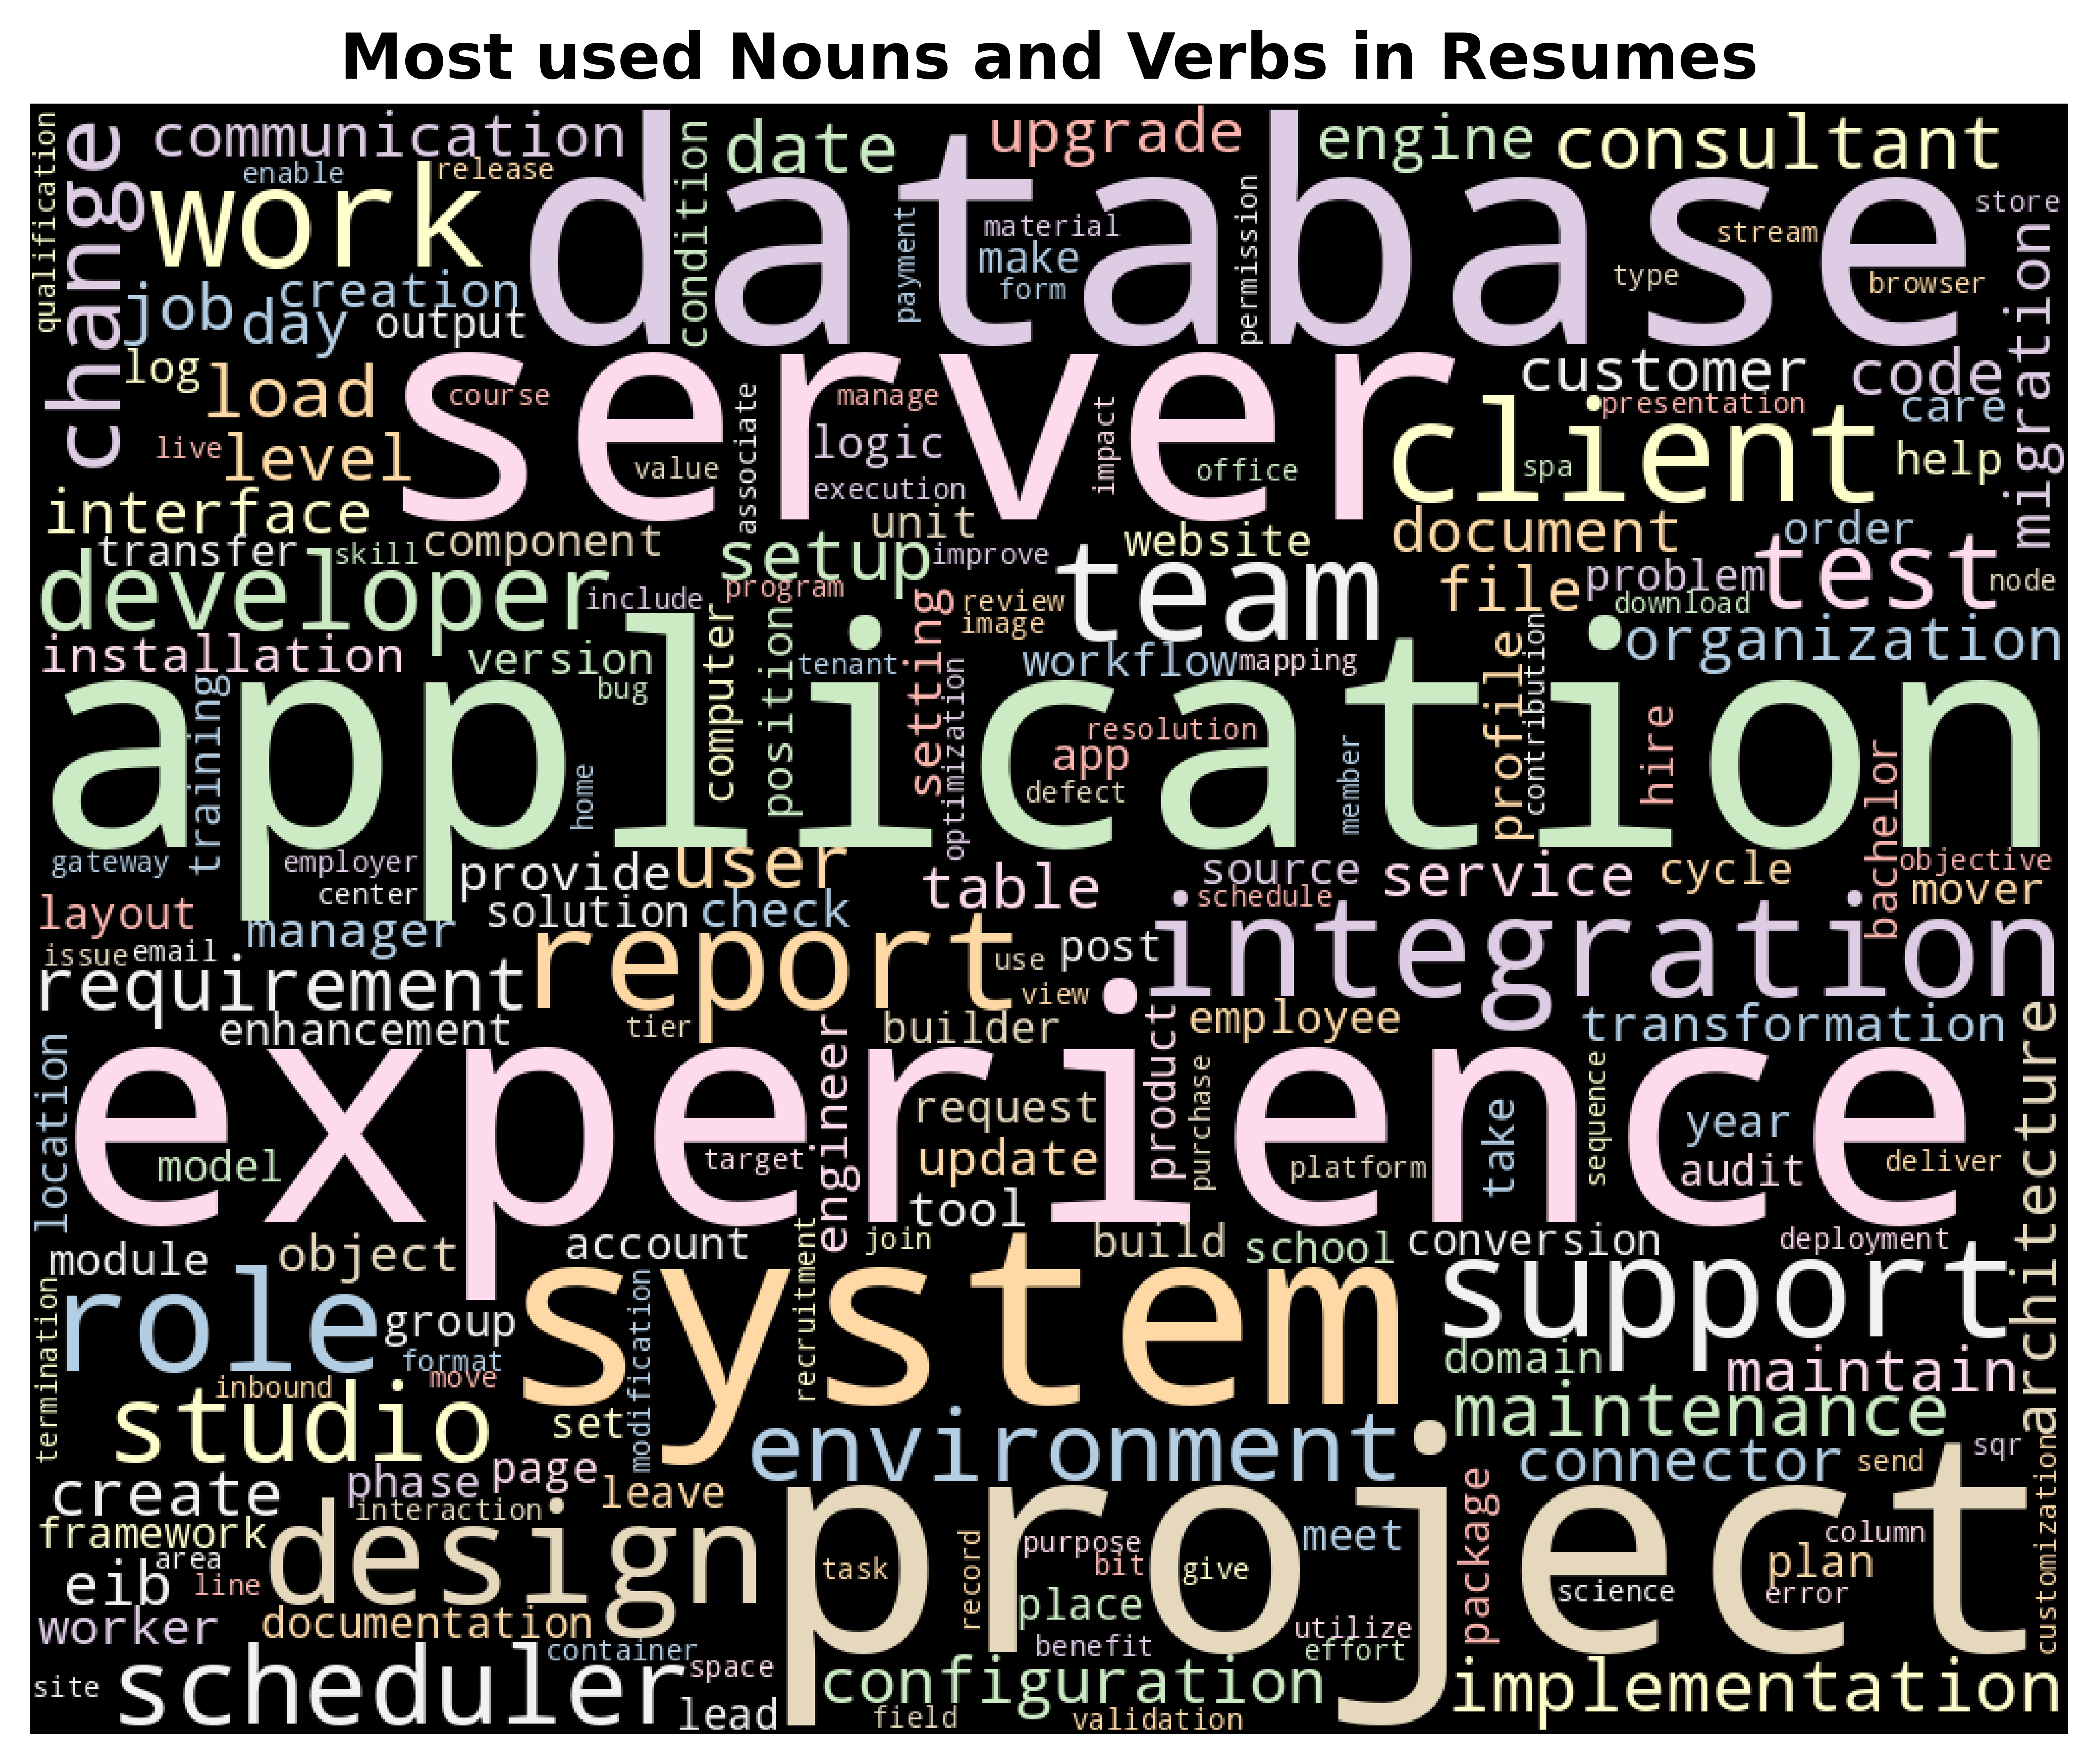

In [28]:
text = " ".join(cat for cat in wd_df.Words) # Creating the text variable

word_cloud = WordCloud(width=1000, height=800, random_state=10, background_color="black", 
                       colormap="Pastel1", collocations=False, stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,7), dpi=800) # Display the generated Word Cloud
plt.title('Most used Nouns and Verbs in Resumes', fontsize= 15, fontweight= 'bold')
plt.imshow(word_cloud)
plt.axis("off")

plt.show()

# B. Exploratory Data Analytics (EDA)

In [30]:
# Import Libraries
import os
import spacy
import docx2txt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
file_path   = './resumes categorised'
print (os.listdir(file_path))

['workday resumes', 'Peoplesoft resumes', 'SQL Developer Lightning insight', 'React', 'Reactjs', 'internship']


In [36]:
file_path   = './resumes categorised/'
doc_file    = []
pdf_file    = []
docx_file   = []
folder_name = []

for folder in os.listdir(file_path):
    folder_path = file_path+folder
    for file in os.listdir(folder_path):
        if file.endswith('.doc'):
            doc_file.append(file)
            folder_name.append(folder)
        elif file.endswith('.docx'):
            docx_file.append(file)
            folder_name.append(folder)
        else:
            pdf_file.append(file)
            folder_name.append(folder)

In [37]:
print('Number of .doc Files  = {}'.format(len(doc_file)),'\n'
      'Number of .pdf Files  = {}'.format(len(pdf_file)),'\n'
      'Number of .docx Files = {}'.format(len(docx_file)))

print("Total Number of Files = ", len(docx_file)+len(doc_file)+len(pdf_file))

Number of .doc Files  = 26 
Number of .pdf Files  = 1 
Number of .docx Files = 52
Total Number of Files =  79


# B1.1 Type of File Format

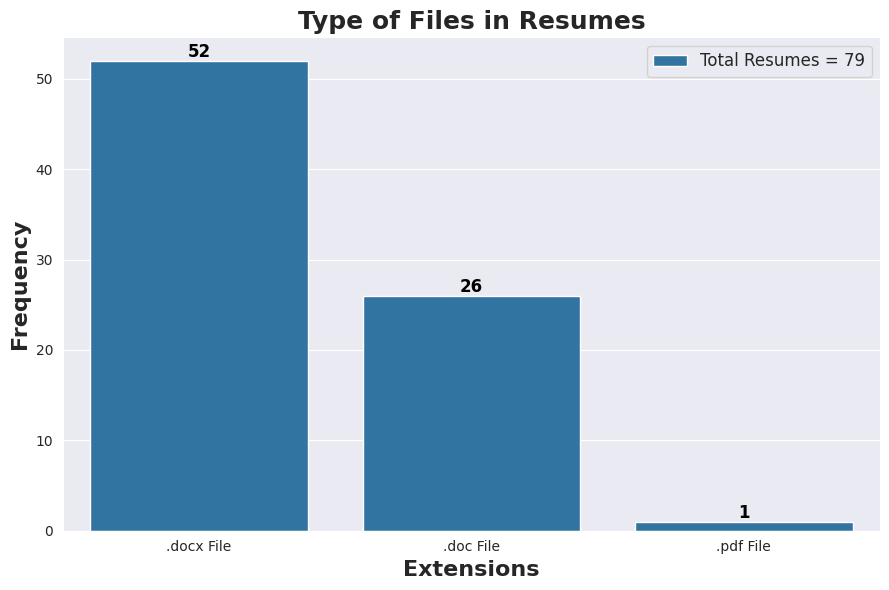

In [38]:
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}
fig, axe = plt.subplots(1,1, figsize=(9,6), dpi=100)
ax = sns.barplot(x=['.docx File','.doc File','.pdf File'], y= [len(docx_file),len(doc_file),len(pdf_file)],
                 ax = axe, label= 'Total Resumes = {}'.format(len(docx_file)+len(doc_file)+len(pdf_file)))

axe.set_xlabel('Extensions', size=16,fontweight = 'bold')
axe.set_ylabel('Frequency', size=16,fontweight = 'bold')
plt.legend(loc='best', fontsize= 'large')
plt.title('Type of Files in Resumes', fontsize= 18, fontweight= 'bold')

for i in ax.containers:
    ax.bar_label(i,color = 'black', fontweight = 'bold', fontsize= 12)
    
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

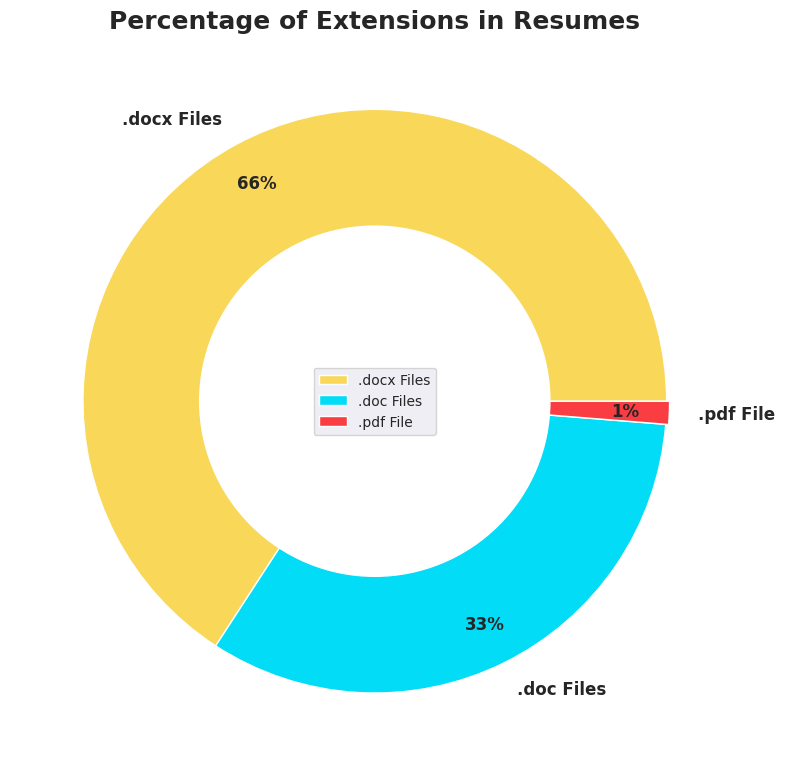

In [39]:
fig = plt.figure(figsize=(8,8), dpi = 100)

sizes = [len(docx_file),len(doc_file),len(pdf_file)]
labels = ['.docx Files','.doc Files','.pdf File']
colors = ['#F9D759', '#03DCF6', '#F93D43']
explode = (0.00, 0.00, 0.01)

plt.pie(sizes, colors= colors, labels= labels, autopct= '%1.0f%%', pctdistance= 0.85, 
        explode= explode, startangle= 0, textprops= {'size':'large', 'fontweight':'bold'})

centre_circle = plt.Circle((0,0), 0.60, fc='w')
fig.gca().add_artist(centre_circle)
plt.title('Percentage of Extensions in Resumes', fontsize= 18, fontweight= 'bold')
plt.legend(labels, loc= "center")

pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

# B2. Extract Resumes by Profile Category

In [42]:
file_path   = './resumes categorised/'
file_name = []
profile   = []
            
for folder in os.listdir(file_path):
    folder_path = file_path+folder
    for file in os.listdir(folder_path):
        if file.endswith('.doc'):
            profile.append(folder)
            file_name.append(file)
        elif file.endswith('.docx'):
            profile.append(folder)
            file_name.append(file)
        else:
            profile.append(folder)
            file_name.append(file)

In [43]:
resume_data = pd.DataFrame()
resume_data['Profile'] = profile
resume_data['Resumes'] = file_name
resume_data

,Profile,Resumes
0,workday resumes,Jyotiverma_Heaware.docx
1,workday resumes,SSKumar_Hexaware.docx
2,workday resumes,P V Sai Krishna_ Hexaware.docx
3,workday resumes,Harikrishna Akula_Hexaware.doc
4,workday resumes,Madeeswar A_Hexaware.doc
...,...,...
74,Reactjs,Reactjs Developer_M Lokesh Babu_Musquare Techn...
75,Reactjs,React JS Developer_AnjaniPriyadarshini.doc
76,Reactjs,Reactjs Developer_kambala sai surendra_Musquar...
77,internship,Internship_Susovan Bag_Musquare Technologies.docx


In [44]:
resume_data.Profile.value_counts().index

Index(['workday resumes', 'Peoplesoft resumes',
       'SQL Developer Lightning insight', 'React', 'Reactjs', 'internship'],
      dtype='object', name='Profile')

In [45]:
resume_data.Profile.value_counts()

Profile
workday resumes                    21
Peoplesoft resumes                 20
SQL Developer Lightning insight    14
React                              11
Reactjs                            11
internship                          2
Name: count, dtype: int64

# B2.1 Number of Total Resumes

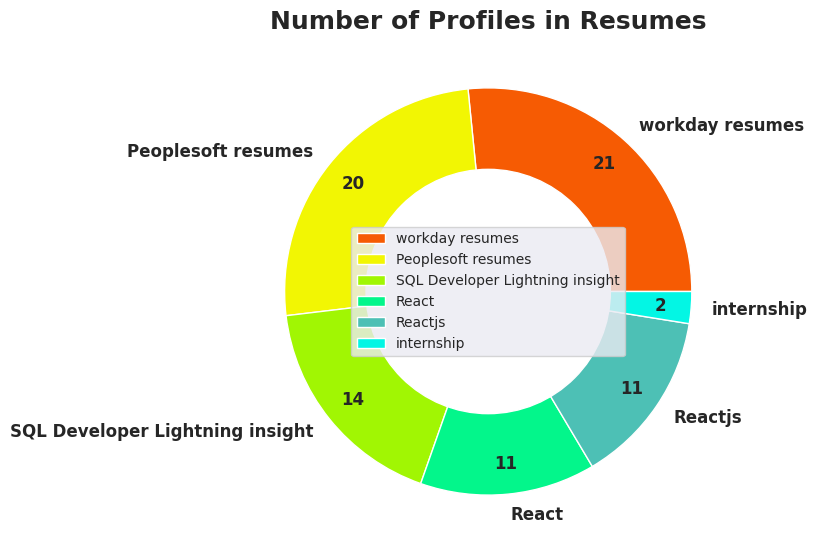

In [46]:
fig = plt.figure(figsize=(8,8))

sizes = resume_data.Profile.value_counts()
labels = resume_data.Profile.value_counts().index
colors = ['#F65B03', '#F2F603', '#A1F603', '#03F68B', '#4dc0b5', '#03F6E4', '#0380F6', '#C603F6', '#E8C110']

plt.pie(sizes, colors= colors, labels= labels, autopct= lambda x:'{:.0f}'.format(x*sizes.sum()/100),
        pctdistance= 0.85, startangle=0, textprops= {'size':'large', 'fontweight':'bold'})

centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)
plt.title('Number of Profiles in Resumes', fontsize= 18, fontweight= 'bold')
plt.legend(labels, loc="center")

pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 79 and the vector passed to `x` has length 6.

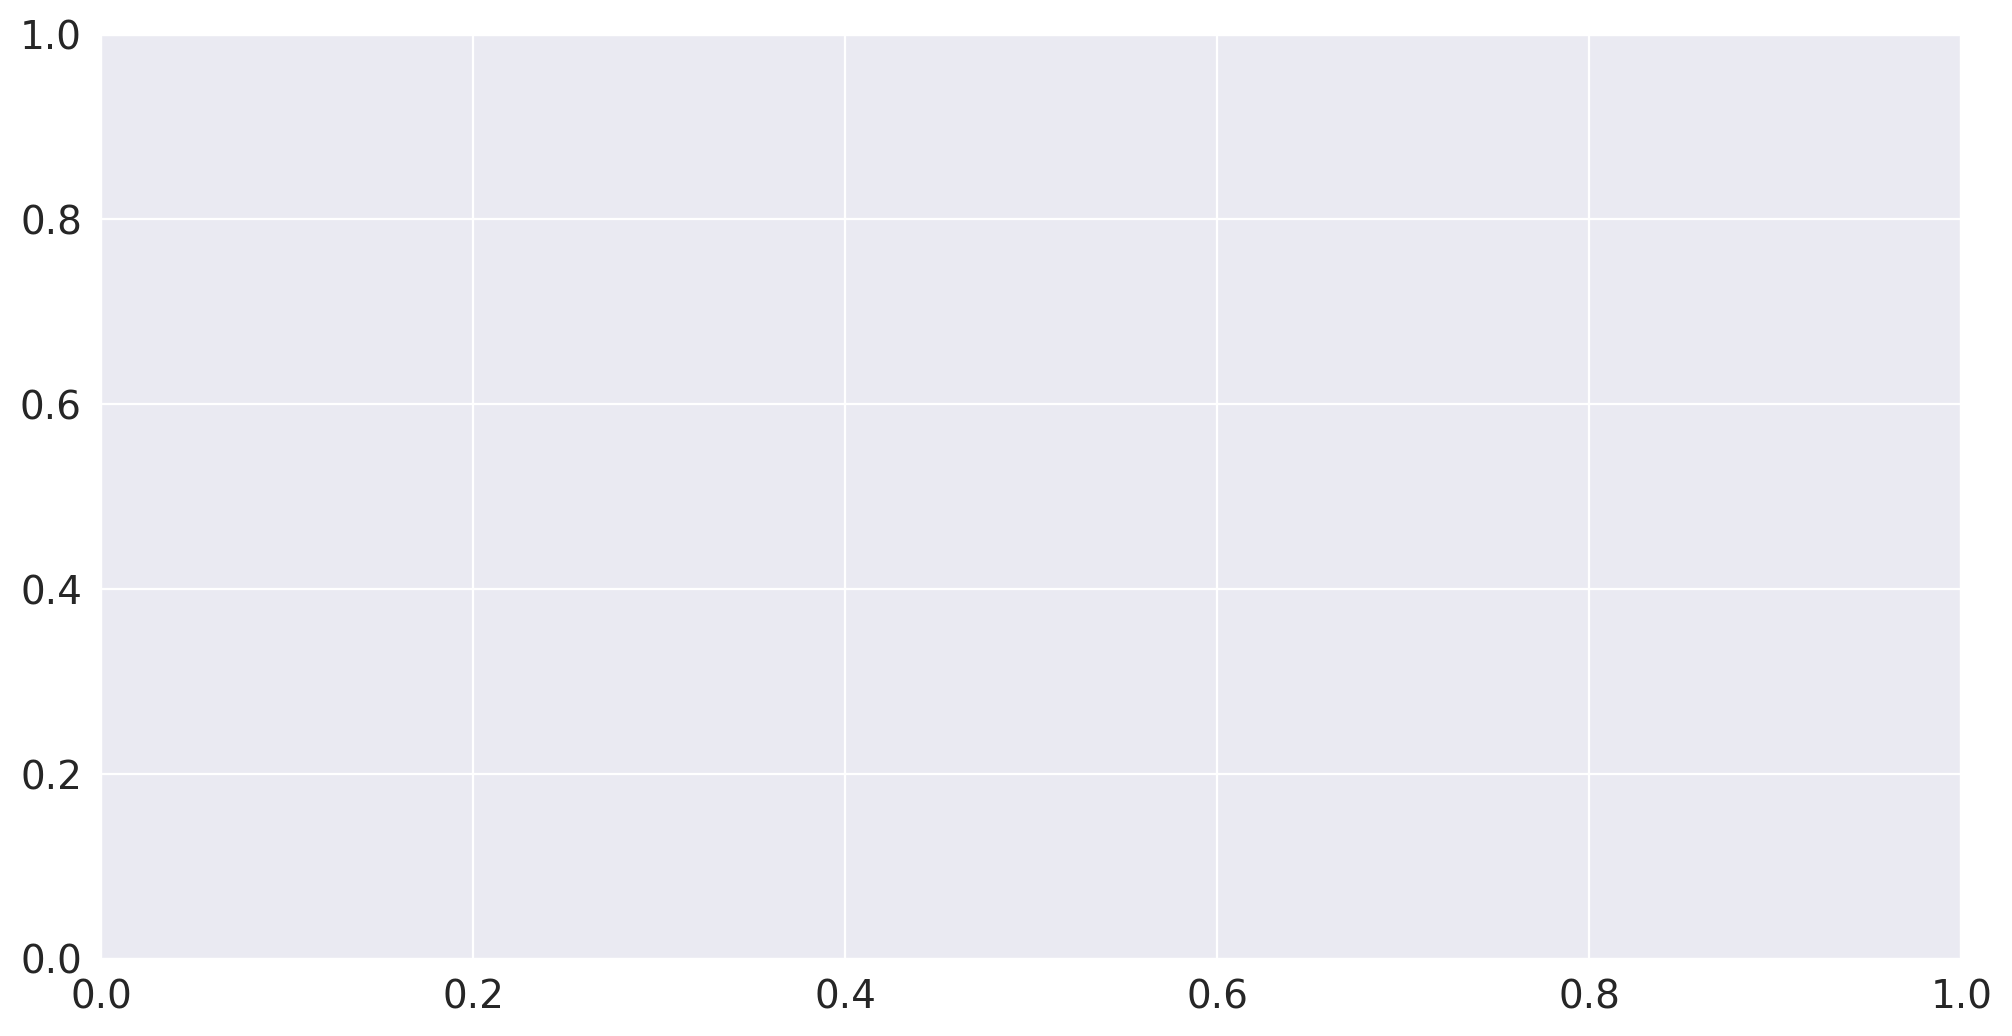

In [47]:
fig, axe = plt.subplots(1,1, figsize=(12,6), dpi=200)
ax = sns.barplot(x= resume_data.Profile.value_counts().index, y= resume_data.Profile.value_counts(), data= resume_data,
                 ax= axe, label= 'Total Pofile Category : {}'.format(len(resume_data.Profile.unique())))

axe.set_xlabel('Profiles', size=16,fontweight = 'bold')
axe.set_ylabel('Frequency', size=16,fontweight = 'bold')
plt.xticks(rotation = 10)
plt.legend(loc='best', fontsize= 'x-large')
plt.title('Number of Profiles in Resumes', fontsize= 20, fontweight= 'bold')

for i in ax.containers:
    ax.bar_label(i,color = 'black', fontweight = 'bold', fontsize= 12)
    
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

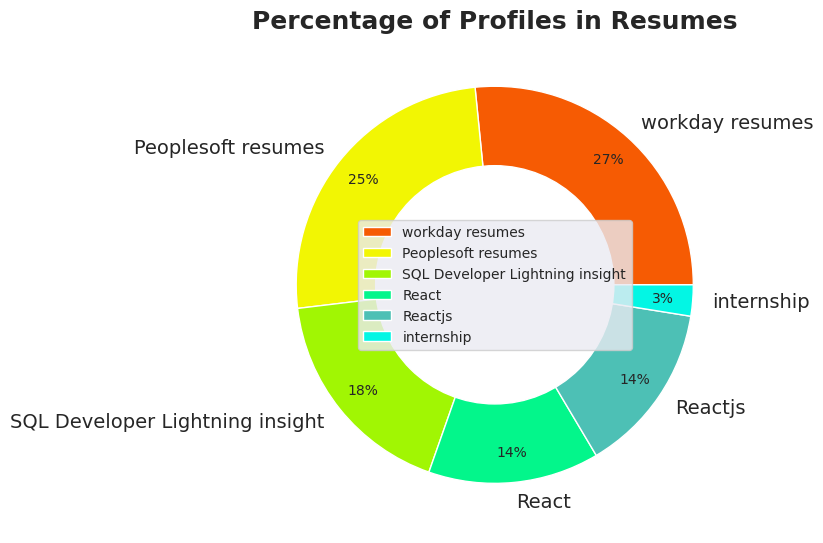

In [48]:
fig = plt.figure(figsize=(8,8),dpi=100) 

sizes = resume_data.Profile.value_counts()
labels = resume_data.Profile.value_counts().index
colors = ['#F65B03', '#F2F603', '#A1F603', '#03F68B', '#4dc0b5', '#03F6E4', '#0380F6', '#C603F6', '#E8C110']
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

plt.pie(sizes, colors= colors, labels= labels, autopct= '%1.0f%%', pctdistance=0.85, 
        startangle= 0)

centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Percentage of Profiles in Resumes', fontsize= 18, fontweight= 'bold')
plt.legend(labels, loc="center")

pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

# B3. Reading a Resume File

In [50]:
def extract_text_from_docx(docx_path):
    txt = docx2txt.process(docx_path)
    if txt:
        return txt.replace('\t', ' ')
    return None
 
print(extract_text_from_docx('/home/its_relative/folder/in_git_hub/Resume-Classification/piyush/resumes categorised/React/React Developer_Haripriya.docx'))

HARIPRIYA BATTINA 

Experience as UI Developer in Reactjs, JavaScript. 

Phone: +91 9908576950 

Gmail: haripriyabattini@gmai.com 

Location: Visakhapatnam 

JOB OBJECTIVE ● Looking for a challenging role to put my experience in various aspects of technology with an objective to be a leading source of information and guidance concerning th

technological requirements. 

● Want to be a part of a reputed organization that allows me to effectively use my 

technical skills in the real world for overall growth of organization and my 

professional career. 

WORK EXPERIENCE EDUCATION 

1. Associate UI Developr 

Company: Blue Yonder, Hyderabad. 

● Work Done On “COPERNICUS” Project. 

● The Main Moto of this project is, it is GTM (Go To Market) Portal which is specially designed for demo teams to shower case Blue Yonder Products and Features for Customers and Partners 

● Technologies: HTML, CSS, React JS. 

● IDE: VS Code. 

● Methodologies: Agile. 

JOB RESPONSIBILITIES: 

● Involved Desi

# B4. Data Exploration

In [51]:
resume_data = pd.read_csv('Cleaned_Resumes.csv')
resume_data

,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details
0,React,361,3702,112,2,developer react developer name krishna profess...
1,React,2435,6115,115,8,pic profile searching opportunity bring years ...
2,React,404,2669,106,6,haripriya battina experience developer reactjs...
3,React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...
4,React,357,2672,48,8,kamalakar reddy linked professional summary ye...
...,...,...,...,...,...,...
74,Reactjs,26196,35291,301,26,curriculum vitae anjani priyadarshini objectiv...
75,Reactjs,435,3299,86,4,ranga gaganam professional summary professiona...
76,Reactjs,474,3111,64,9,shaik abdul sharuk years experience wipro care...
77,Reactjs,945,2967,67,4,mareedu lokesh babu professional overview arou...


# B4.1 N-grams

In [52]:
TextBlob(resume_data['Resume_Details'][1]).ngrams(1)[:20]

[WordList(['pic']),
 WordList(['profile']),
 WordList(['searching']),
 WordList(['opportunity']),
 WordList(['bring']),
 WordList(['years']),
 WordList(['experience']),
 WordList(['software']),
 WordList(['developing']),
 WordList(['technology']),
 WordList(['engineering']),
 WordList(['designing']),
 WordList(['maintenance']),
 WordList(['cater']),
 WordList(['specific']),
 WordList(['needs']),
 WordList(['people']),
 WordList(['critical']),
 WordList(['thinking']),
 WordList(['problem'])]

In [53]:
TextBlob(resume_data['Resume_Details'][1]).ngrams(2)[:20]

[WordList(['pic', 'profile']),
 WordList(['profile', 'searching']),
 WordList(['searching', 'opportunity']),
 WordList(['opportunity', 'bring']),
 WordList(['bring', 'years']),
 WordList(['years', 'experience']),
 WordList(['experience', 'software']),
 WordList(['software', 'developing']),
 WordList(['developing', 'technology']),
 WordList(['technology', 'engineering']),
 WordList(['engineering', 'designing']),
 WordList(['designing', 'maintenance']),
 WordList(['maintenance', 'cater']),
 WordList(['cater', 'specific']),
 WordList(['specific', 'needs']),
 WordList(['needs', 'people']),
 WordList(['people', 'critical']),
 WordList(['critical', 'thinking']),
 WordList(['thinking', 'problem']),
 WordList(['problem', 'solving'])]

In [54]:
TextBlob(resume_data['Resume_Details'][1]).ngrams(3)[:20]

[WordList(['pic', 'profile', 'searching']),
 WordList(['profile', 'searching', 'opportunity']),
 WordList(['searching', 'opportunity', 'bring']),
 WordList(['opportunity', 'bring', 'years']),
 WordList(['bring', 'years', 'experience']),
 WordList(['years', 'experience', 'software']),
 WordList(['experience', 'software', 'developing']),
 WordList(['software', 'developing', 'technology']),
 WordList(['developing', 'technology', 'engineering']),
 WordList(['technology', 'engineering', 'designing']),
 WordList(['engineering', 'designing', 'maintenance']),
 WordList(['designing', 'maintenance', 'cater']),
 WordList(['maintenance', 'cater', 'specific']),
 WordList(['cater', 'specific', 'needs']),
 WordList(['specific', 'needs', 'people']),
 WordList(['needs', 'people', 'critical']),
 WordList(['people', 'critical', 'thinking']),
 WordList(['critical', 'thinking', 'problem']),
 WordList(['thinking', 'problem', 'solving']),
 WordList(['problem', 'solving', 'leadership'])]

In [55]:
resume_data['Resume_Details']

0     developer react developer name krishna profess...
1     pic profile searching opportunity bring years ...
2     haripriya battina experience developer reactjs...
3     sarala madasu sarala madasu sri geethika prest...
4     kamalakar reddy linked professional summary ye...
                            ...                        
74    curriculum vitae anjani priyadarshini objectiv...
75    ranga gaganam professional summary professiona...
76    shaik abdul sharuk years experience wipro care...
77    mareedu lokesh babu professional overview arou...
78    venkatalakshmi pedireddy software developer ex...
Name: Resume_Details, Length: 79, dtype: object

# B4.2 Top 20 most used words in Resumes

## B4.2.1 Using the Word Clowds

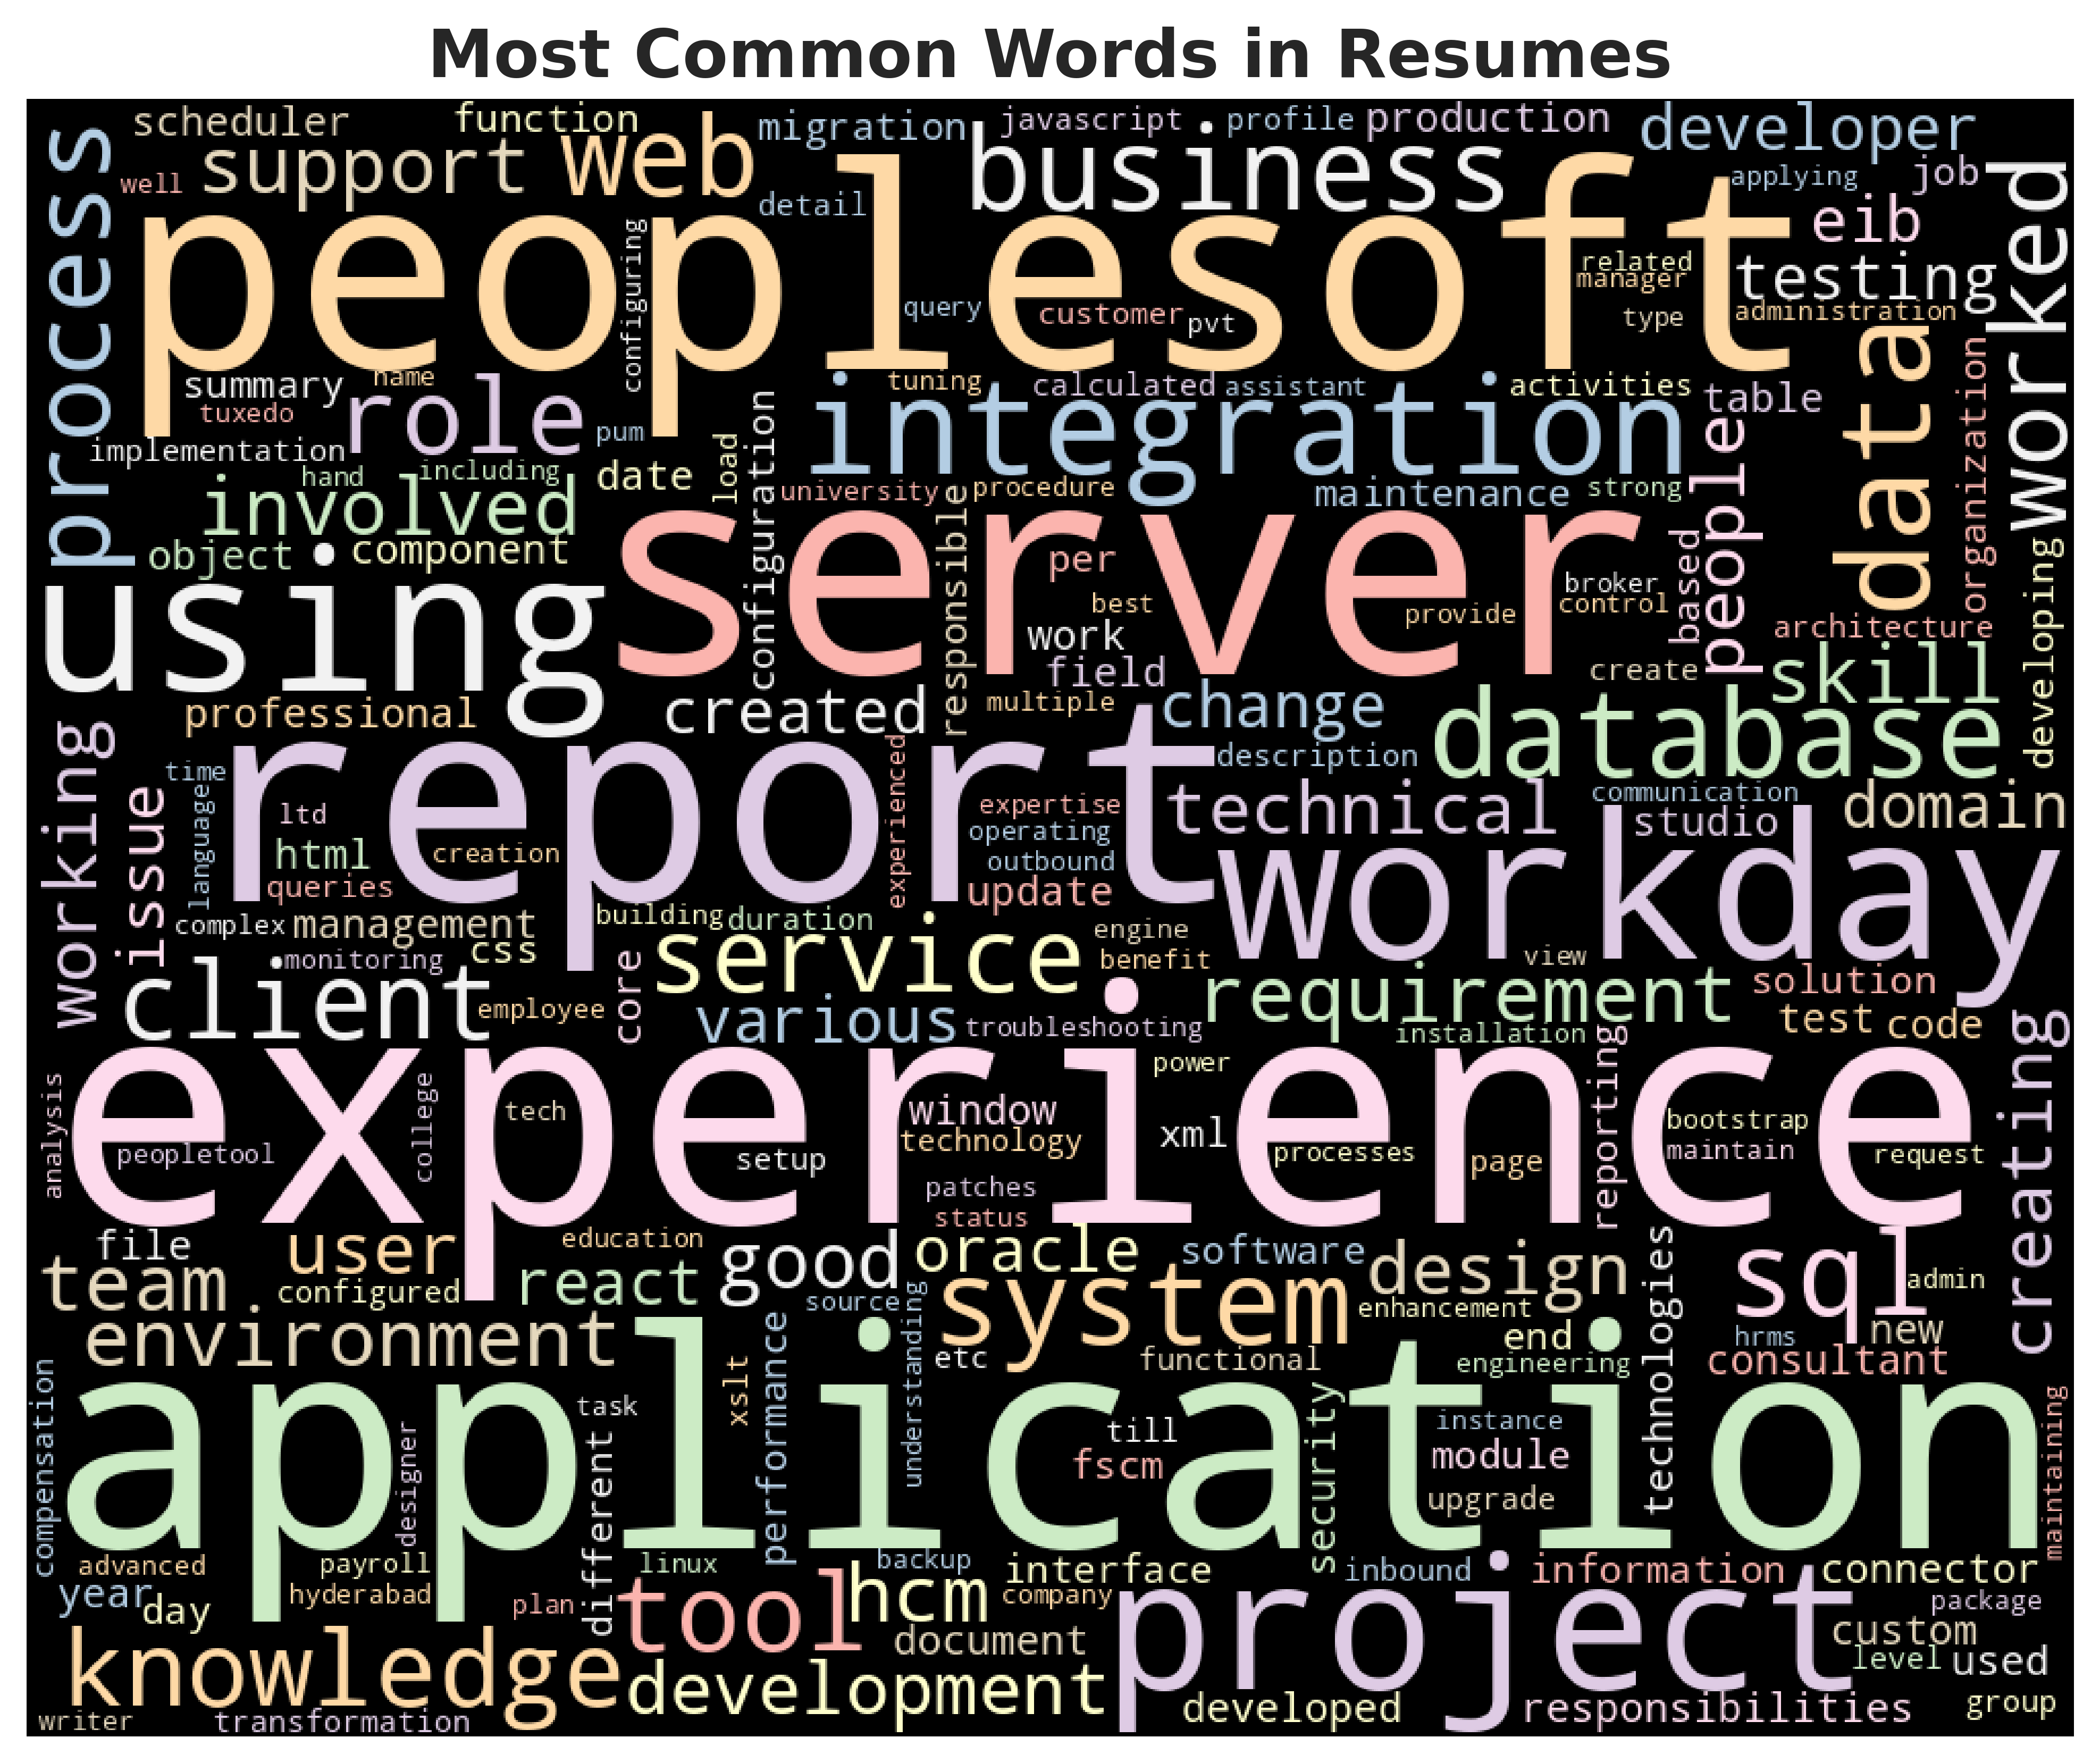

In [56]:
text = " ".join(cat for cat in resume_data.Resume_Details) # Creating the text variable

word_cloud = WordCloud(width=1000, height=800, random_state=10, background_color="black", 
                       colormap="Pastel1", collocations=False, stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,8), dpi=500) # Display the generated Word Cloud
plt.title('Most Common Words in Resumes', fontsize= 18, fontweight= 'bold')
plt.imshow(word_cloud)
plt.axis("off")

plt.show()

# C. Model Buidling

# C1. Import Library 

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_score


import warnings
warnings.filterwarnings('ignore')

# C2. Load Data

In [59]:
resume_data = pd.read_csv('Cleaned_Resumes.csv')
resume_data.head()

,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details
0,React,361,3702,112,2,developer react developer name krishna profess...
1,React,2435,6115,115,8,pic profile searching opportunity bring years ...
2,React,404,2669,106,6,haripriya battina experience developer reactjs...
3,React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...
4,React,357,2672,48,8,kamalakar reddy linked professional summary ye...


# C3. Data Preprocessing

## 3.1 LabelEncoder

In [61]:
from sklearn.preprocessing import LabelEncoder
Encoder=LabelEncoder()
resume_data["LebelEncoding"]=Encoder.fit_transform(resume_data ["Category1"])

resume_data

,Category1,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details,LebelEncoding
0,React,361,3702,112,2,developer react developer name krishna profess...,1
1,React,2435,6115,115,8,pic profile searching opportunity bring years ...,1
2,React,404,2669,106,6,haripriya battina experience developer reactjs...,1
3,React,349,3156,93,5,sarala madasu sarala madasu sri geethika prest...,1
4,React,357,2672,48,8,kamalakar reddy linked professional summary ye...,1
...,...,...,...,...,...,...,...
74,Reactjs,26196,35291,301,26,curriculum vitae anjani priyadarshini objectiv...,2
75,Reactjs,435,3299,86,4,ranga gaganam professional summary professiona...,2
76,Reactjs,474,3111,64,9,shaik abdul sharuk years experience wipro care...,2
77,Reactjs,945,2967,67,4,mareedu lokesh babu professional overview arou...,2


In [62]:
resume_data.describe()

,Word_Count,Char_Count,Stopwords,Numerics,LebelEncoding
count,79.000000,79.000000,79.000000,79.000000,79.000000
mean,1569.025316,6252.569620,157.278481,6.784810,2.379747
std,3061.696551,4914.965484,103.301517,5.443582,1.930217
min,181.000000,1773.000000,34.000000,0.000000,0.000000
25%,495.000000,3376.500000,90.500000,3.000000,0.500000
50%,769.000000,4819.000000,136.000000,6.000000,2.000000
75%,1594.000000,7839.500000,194.000000,8.000000,5.000000
max,26196.000000,35291.000000,640.000000,26.000000,5.000000


In [63]:
resume_data.isnull().sum()

Category1         0
Word_Count        0
Char_Count        0
Stopwords         0
Numerics          0
Resume_Details    0
LebelEncoding     0
dtype: int64

# C4. Model Building

## C4.1 Train - Test Split

In [65]:
x = resume_data['Resume_Details'].values
y = resume_data['Category1'].values

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=45, test_size=0.25,stratify=y)
x_train.shape, x_test.shape

((59,), (20,))

# C4.2 TF-IDF Vectorization

In [67]:
tfidf_vector = TfidfVectorizer(sublinear_tf=True,stop_words='english')

In [68]:
x_train = tfidf_vector.fit_transform(x_train)
x_test = tfidf_vector.transform(x_test)
x_train.shape, x_test.shape

((59, 3672), (20, 3672))

In [69]:
print(y_train),print(y_test)

['Peoplesoft resumes' 'Reactjs' 'Peoplesoft resumes' 'workday resumes'
 'SQL Developer Lightning insight' 'SQL Developer Lightning insight'
 'React' 'Peoplesoft resumes' 'SQL Developer Lightning insight'
 'Peoplesoft resumes' 'React' 'SQL Developer Lightning insight' 'Reactjs'
 'React' 'workday resumes' 'React' 'internship'
 'SQL Developer Lightning insight' 'Peoplesoft resumes' 'Reactjs'
 'Reactjs' 'workday resumes' 'Peoplesoft resumes' 'Peoplesoft resumes'
 'Peoplesoft resumes' 'SQL Developer Lightning insight' 'workday resumes'
 'workday resumes' 'workday resumes' 'Reactjs' 'workday resumes' 'React'
 'SQL Developer Lightning insight' 'workday resumes' 'Reactjs'
 'workday resumes' 'SQL Developer Lightning insight' 'workday resumes'
 'Peoplesoft resumes' 'Peoplesoft resumes'
 'SQL Developer Lightning insight' 'Peoplesoft resumes' 'workday resumes'
 'SQL Developer Lightning insight' 'Peoplesoft resumes' 'workday resumes'
 'Peoplesoft resumes' 'internship' 'workday resumes' 'workday res

(None, None)

# C5. Classification Models

## C5.1 KNN Classifier

In [70]:
model_knn = KNeighborsClassifier(n_neighbors=41)
model_knn.fit(x_train, y_train)
y_pred = model_knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_knn.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_knn.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_knn,classification_report(y_test, y_pred)))
nb_score = model_knn.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_knn = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_knn = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_knn = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_knn = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 0.34
Accuracy of  test set    : 0.35
Classification report for classifier KNeighborsClassifier(n_neighbors=41):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.50      0.40      0.44         5
                          React       0.00      0.00      0.00         3
                        Reactjs       0.00      0.00      0.00         3
SQL Developer Lightning insight       0.00      0.00      0.00         4
                workday resumes       0.31      1.00      0.48         5

                       accuracy                           0.35        20
                      macro avg       0.16      0.28      0.18        20
                   weighted avg       0.20      0.35      0.23        20




## C5.2 Decision Tree Classifier

In [71]:
model_DT = DecisionTreeClassifier(criterion='gini')
model_DT.fit(x_train, y_train)
y_pred = model_DT.predict(x_test)
accuracy_DT = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_DT.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_DT.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_DT,classification_report(y_test, y_pred)))
nb_score = model_DT.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_DT = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_DT= round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_DT = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_DT = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 1.00
Accuracy of  test set    : 0.90
Classification report for classifier DecisionTreeClassifier():
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         5
                          React       1.00      0.33      0.50         3
                        Reactjs       0.60      1.00      0.75         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.90        20
                      macro avg       0.92      0.87      0.85        20
                   weighted avg       0.94      0.90      0.89        20




## C5.3 Random Forest Classifier

In [72]:
model_RF = RandomForestClassifier(n_estimators=200)
model_RF.fit(x_train, y_train)
y_pred = model_RF.predict(x_test)
accuracy_RF = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_RF.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_RF.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_RF,classification_report(y_test, y_pred)))
nb_score = model_RF.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)


precision_RF = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_RF = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_RF = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_RF = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 1.00
Accuracy of  test set    : 0.75
Classification report for classifier RandomForestClassifier(n_estimators=200):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         5
                          React       0.25      0.33      0.29         3
                        Reactjs       0.00      0.00      0.00         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.75        20
                      macro avg       0.65      0.67      0.66        20
                   weighted avg       0.74      0.75      0.74        20




## C5.4 Support Vectore Machine (SVM) Classifier

In [73]:
model_svm = SVC()
model_svm.fit(x_train, y_train)
y_pred = model_svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_svm.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_svm.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_svm,classification_report(y_test, y_pred)))
nb_score = model_svm.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_svm = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_svm = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_svm = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_svm = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 1.00
Accuracy of  test set    : 0.90
Classification report for classifier SVC():
                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.83      1.00      0.91         5
                          React       0.67      0.67      0.67         3
                        Reactjs       1.00      0.67      0.80         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.90        20
                      macro avg       0.90      0.87      0.88        20
                   weighted avg       0.91      0.90      0.90        20




## C5.5 Logistic Regression

In [74]:
model_lgr = LogisticRegression()
model_lgr.fit(x_train, y_train)
y_pred = model_lgr.predict(x_test)
accuracy_lgr = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_lgr.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_lgr.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_lgr,classification_report(y_test, y_pred)))
nb_score = model_lgr.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)


precision_lgr = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_lgr = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_lgr = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_lgr = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 0.97
Accuracy of  test set    : 0.90
Classification report for classifier LogisticRegression():
                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.83      1.00      0.91         5
                          React       0.67      0.67      0.67         3
                        Reactjs       1.00      0.67      0.80         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.90        20
                      macro avg       0.90      0.87      0.88        20
                   weighted avg       0.91      0.90      0.90        20




## C5.6 Bagging Classifier

In [75]:
model_bagg = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
model_bagg.fit(x_train, y_train)
y_pred = model_bagg.predict(x_test)
accuracy_bagg = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_bagg.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_bagg.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_bagg,classification_report(y_test, y_pred)))
nb_score = model_bagg.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_bagg = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_bagg = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_bagg = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_bagg = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 0.88
Accuracy of  test set    : 0.75
Classification report for classifier BaggingClassifier(estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         5
                          React       0.00      0.00      0.00         3
                        Reactjs       0.25      0.33      0.29         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.75        20
                      macro avg       0.65      0.67      0.66        20
                   weighted avg       0.74      0.75      0.74        20




## C5.7 AdaBoost Classifier

In [76]:
model_Adaboost = AdaBoostClassifier(n_estimators=100)
model_Adaboost.fit(x_train, y_train)
y_pred = model_Adaboost.predict(x_test)
accuracy_Adaboost = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_Adaboost.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_Adaboost.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_Adaboost,classification_report(y_test, y_pred)))
nb_score = model_Adaboost.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_Adaboost = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_Adaboost = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_Adaboost = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_Adaboost = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 0.83
Accuracy of  test set    : 0.80
Classification report for classifier AdaBoostClassifier(n_estimators=100):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      0.80      0.89         5
                          React       0.43      1.00      0.60         3
                        Reactjs       0.00      0.00      0.00         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.80        20
                      macro avg       0.69      0.76      0.70        20
                   weighted avg       0.76      0.80      0.76        20




## C5.8 Gradient Boosting Classifier

In [77]:
model_GradientBoost = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1, random_state=0)
model_GradientBoost.fit(x_train, y_train)
y_pred = model_GradientBoost.predict(x_test)
accuracy_GradientBoost = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_GradientBoost.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_GradientBoost.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_GradientBoost,classification_report(y_test, y_pred)))
nb_score = model_GradientBoost.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_Gradientboost = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_Gradientboost = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_Gradientboost = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_Gradientboost = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 1.00
Accuracy of  test set    : 0.80
Classification report for classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      0.80      0.89         5
                          React       0.50      0.67      0.57         3
                        Reactjs       0.33      0.33      0.33         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.80        20
                      macro avg       0.77      0.76      0.76        20
                   weighted avg       0.82      0.80      0.81        20




## C5.9 Naive Bayes Classifier

In [78]:
model_NB =MultinomialNB(alpha=1, fit_prior=False, class_prior=None)
model_NB.fit(x_train, y_train)
y_pred = model_NB.predict(x_test)
accuracy_NB = accuracy_score(y_test, y_pred)
print('Accuracy of training set : {:.2f}'.format(model_NB.score(x_train, y_train)))
print('Accuracy of  test set    : {:.2f}'.format(model_NB.score(x_test, y_test)))
print("Classification report for classifier %s:\n%s\n" % (model_NB,classification_report(y_test, y_pred)))
nb_score = model_NB.score(x_test, y_test)
nb_cm = confusion_matrix(y_test, y_pred)

precision_NB = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_NB = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_NB = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_NB = round(accuracy_score(y_test,y_pred),2)

Accuracy of training set : 1.00
Accuracy of  test set    : 0.90
Classification report for classifier MultinomialNB(alpha=1, fit_prior=False):
                                 precision    recall  f1-score   support

             Peoplesoft resumes       0.83      1.00      0.91         5
                          React       0.67      0.67      0.67         3
                        Reactjs       1.00      0.67      0.80         3
SQL Developer Lightning insight       1.00      1.00      1.00         4
                workday resumes       1.00      1.00      1.00         5

                       accuracy                           0.90        20
                      macro avg       0.90      0.87      0.88        20
                   weighted avg       0.91      0.90      0.90        20




# C6. Model Evaluation

In [79]:
Evaluation = {"Models":["KNN Classifier","DecisionTree Classifier","RandomForest Classifier","SVM Classifier",
                        "Logistic Regression","Bagging Classifier","AdaBoost Classifier","Gradient Boosting Classifier","Naive Bayes Classifier"],\
            "Train_Accuracy(%)":[model_knn.score(x_train, y_train),model_DT.score(x_train, y_train),model_RF.score(x_train, y_train),model_svm.score(x_train, y_train),model_lgr.score(x_train, y_train),
                                 model_bagg.score(x_train, y_train),model_Adaboost.score(x_train, y_train),model_GradientBoost.score(x_train, y_train), model_NB.score(x_train, y_train)],
            "Test_Accuracy(%)":[accuracy_knn,accuracy_DT,accuracy_RF,accuracy_svm,accuracy_lgr,accuracy_bagg,accuracy_Adaboost,accuracy_GradientBoost,accuracy_NB],\
            "Precision(%)":[precision_knn,precision_DT,precision_RF,precision_svm,precision_lgr,precision_bagg,precision_Adaboost,precision_Gradientboost,precision_NB],\
            "Recall(%)":[recall_knn,recall_DT,recall_RF,recall_svm,recall_lgr,recall_bagg,recall_Adaboost,recall_Gradientboost,recall_NB],\
            "F1-Score(%)":[f1_knn,f1_DT,f1_RF,f1_svm,f1_lgr,f1_bagg,f1_Adaboost,f1_Gradientboost,f1_NB]}
table = pd.DataFrame(Evaluation)
table

,Models,Train_Accuracy(%),Test_Accuracy(%),Precision(%),Recall(%),F1-Score(%)
0,KNN Classifier,0.338983,0.35,0.16,0.28,0.18
1,DecisionTree Classifier,1.000000,0.90,0.92,0.87,0.85
2,RandomForest Classifier,1.000000,0.75,0.65,0.67,0.66
3,SVM Classifier,1.000000,0.90,0.90,0.87,0.88
4,Logistic Regression,0.966102,0.90,0.90,0.87,0.88
5,Bagging Classifier,0.881356,0.75,0.65,0.67,0.66
6,AdaBoost Classifier,0.830508,0.80,0.69,0.76,0.70
7,Gradient Boosting Classifier,1.000000,0.80,0.77,0.76,0.76
8,Naive Bayes Classifier,1.000000,0.90,0.90,0.87,0.88


In [80]:
model_names = ["KNN","DecisionTree","RandomForest ","SVM ", "Logistic Regression",
               "Bagging","AdaBoost","Gradient Boosting ","Naive Bayes"]
Test_accuracies = [accuracy_knn*100,accuracy_DT*100,accuracy_RF*100,
              accuracy_svm*100,accuracy_lgr*100,accuracy_bagg*100,
              accuracy_Adaboost*100,accuracy_GradientBoost*100,accuracy_NB*100]
Train_accuracies=[model_knn.score(x_train, y_train)*100,model_DT.score(x_train, y_train)*100,
                  model_RF.score(x_train, y_train)*100,model_svm.score(x_train, y_train)*100,
                  model_lgr.score(x_train, y_train)*100,model_bagg.score(x_train, y_train)*100,
                  model_Adaboost.score(x_train, y_train)*100,model_GradientBoost.score(x_train, y_train)*100,
                  model_NB.score(x_train, y_train)*100]

## C6.1 Train and Test Accuracy Plot 

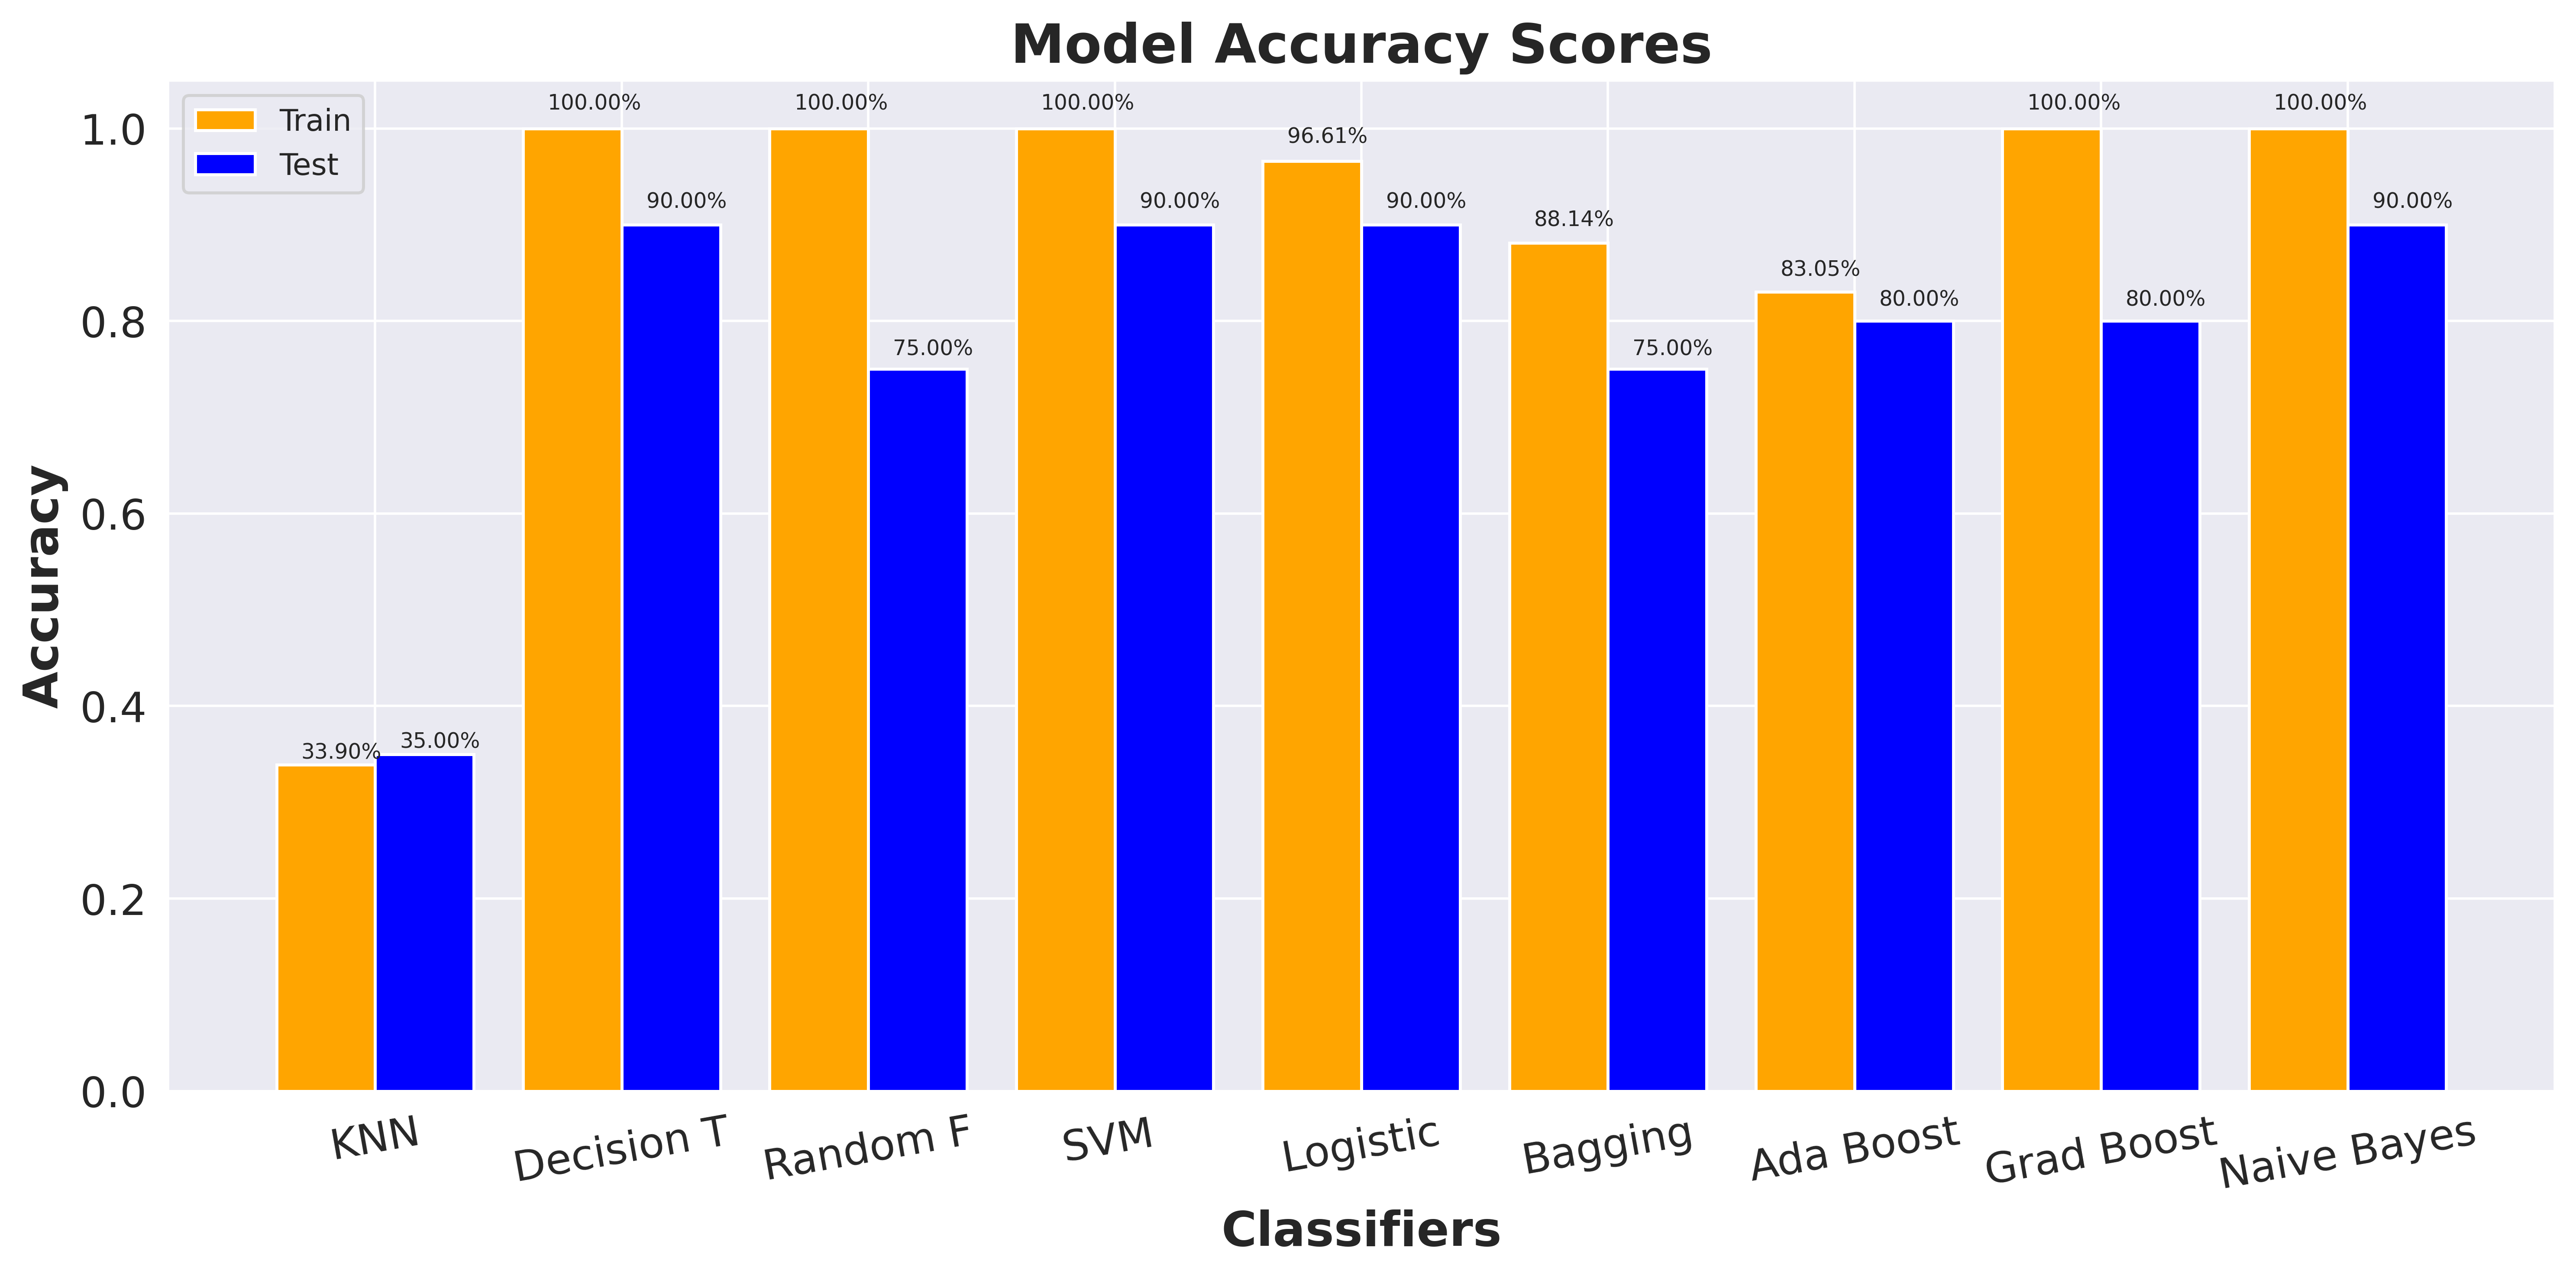

In [81]:
rcParams = {'xtick.labelsize':'12','ytick.labelsize':'14','axes.labelsize':'16'}
fig, axe = plt.subplots(1,1, figsize=(12,6), dpi=500)
x_pos = np.arange(len(table))
model_names = ["KNN", "Decision T", "Random F", "SVM ", "Logistic", "Bagging", "Ada Boost", "Grad Boost","Naive Bayes"]

bar1 = plt.bar(x_pos - 0.2, table['Train_Accuracy(%)'], width=0.4, label='Train', color= "Orange")
bar2 = plt.bar(x_pos + 0.2, table['Test_Accuracy(%)'], width=0.4, label='Test', color= "b")
plt.xticks(x_pos, model_names)

plt.xlabel("Classifiers", fontsize = 16, fontweight = 'bold')
plt.ylabel("Accuracy", fontsize = 16, fontweight = 'bold')
plt.title("Model Accuracy Scores", fontsize = 18, fontweight = 'bold')
plt.xticks(rotation = 10)
plt.legend()

for i, bar in enumerate(bar1):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, bar.get_height()*1.02, 
             s = '{:.2f}%'.format(Train_accuracies[i]), fontsize = 7)
    
for i, bar in enumerate(bar2):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, bar.get_height()*1.02, 
             s = '{:.2f}%'.format(Test_accuracies[i]), fontsize = 7)

pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

# D. Model Deployment

## D1. Pickle File

In [82]:
import pickle
filename = 'modelSAP.pkl'
pickle.dump(model_RF,open(filename,'wb'))
pickle.dump(tfidf_vector,open(filename,'wb'))